In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,inputs,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2023-09-15 11:09:54.825992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Define Network Parameters

In [3]:
def fio_rect(x):
#     x[x<0] = 0
#     return x
    return np.fmax(x,0)

In [4]:
N = 96
Nret = N
Nlgn = N

xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
dxs = np.abs(xs.flatten()[:,None] - xs.flatten()[None,:])
dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
dys = np.abs(ys.flatten()[:,None] - ys.flatten()[None,:])
dys[dys > 0.5] = 1 - dys[dys > 0.5]
ds = np.sqrt(dxs**2 + dys**2)

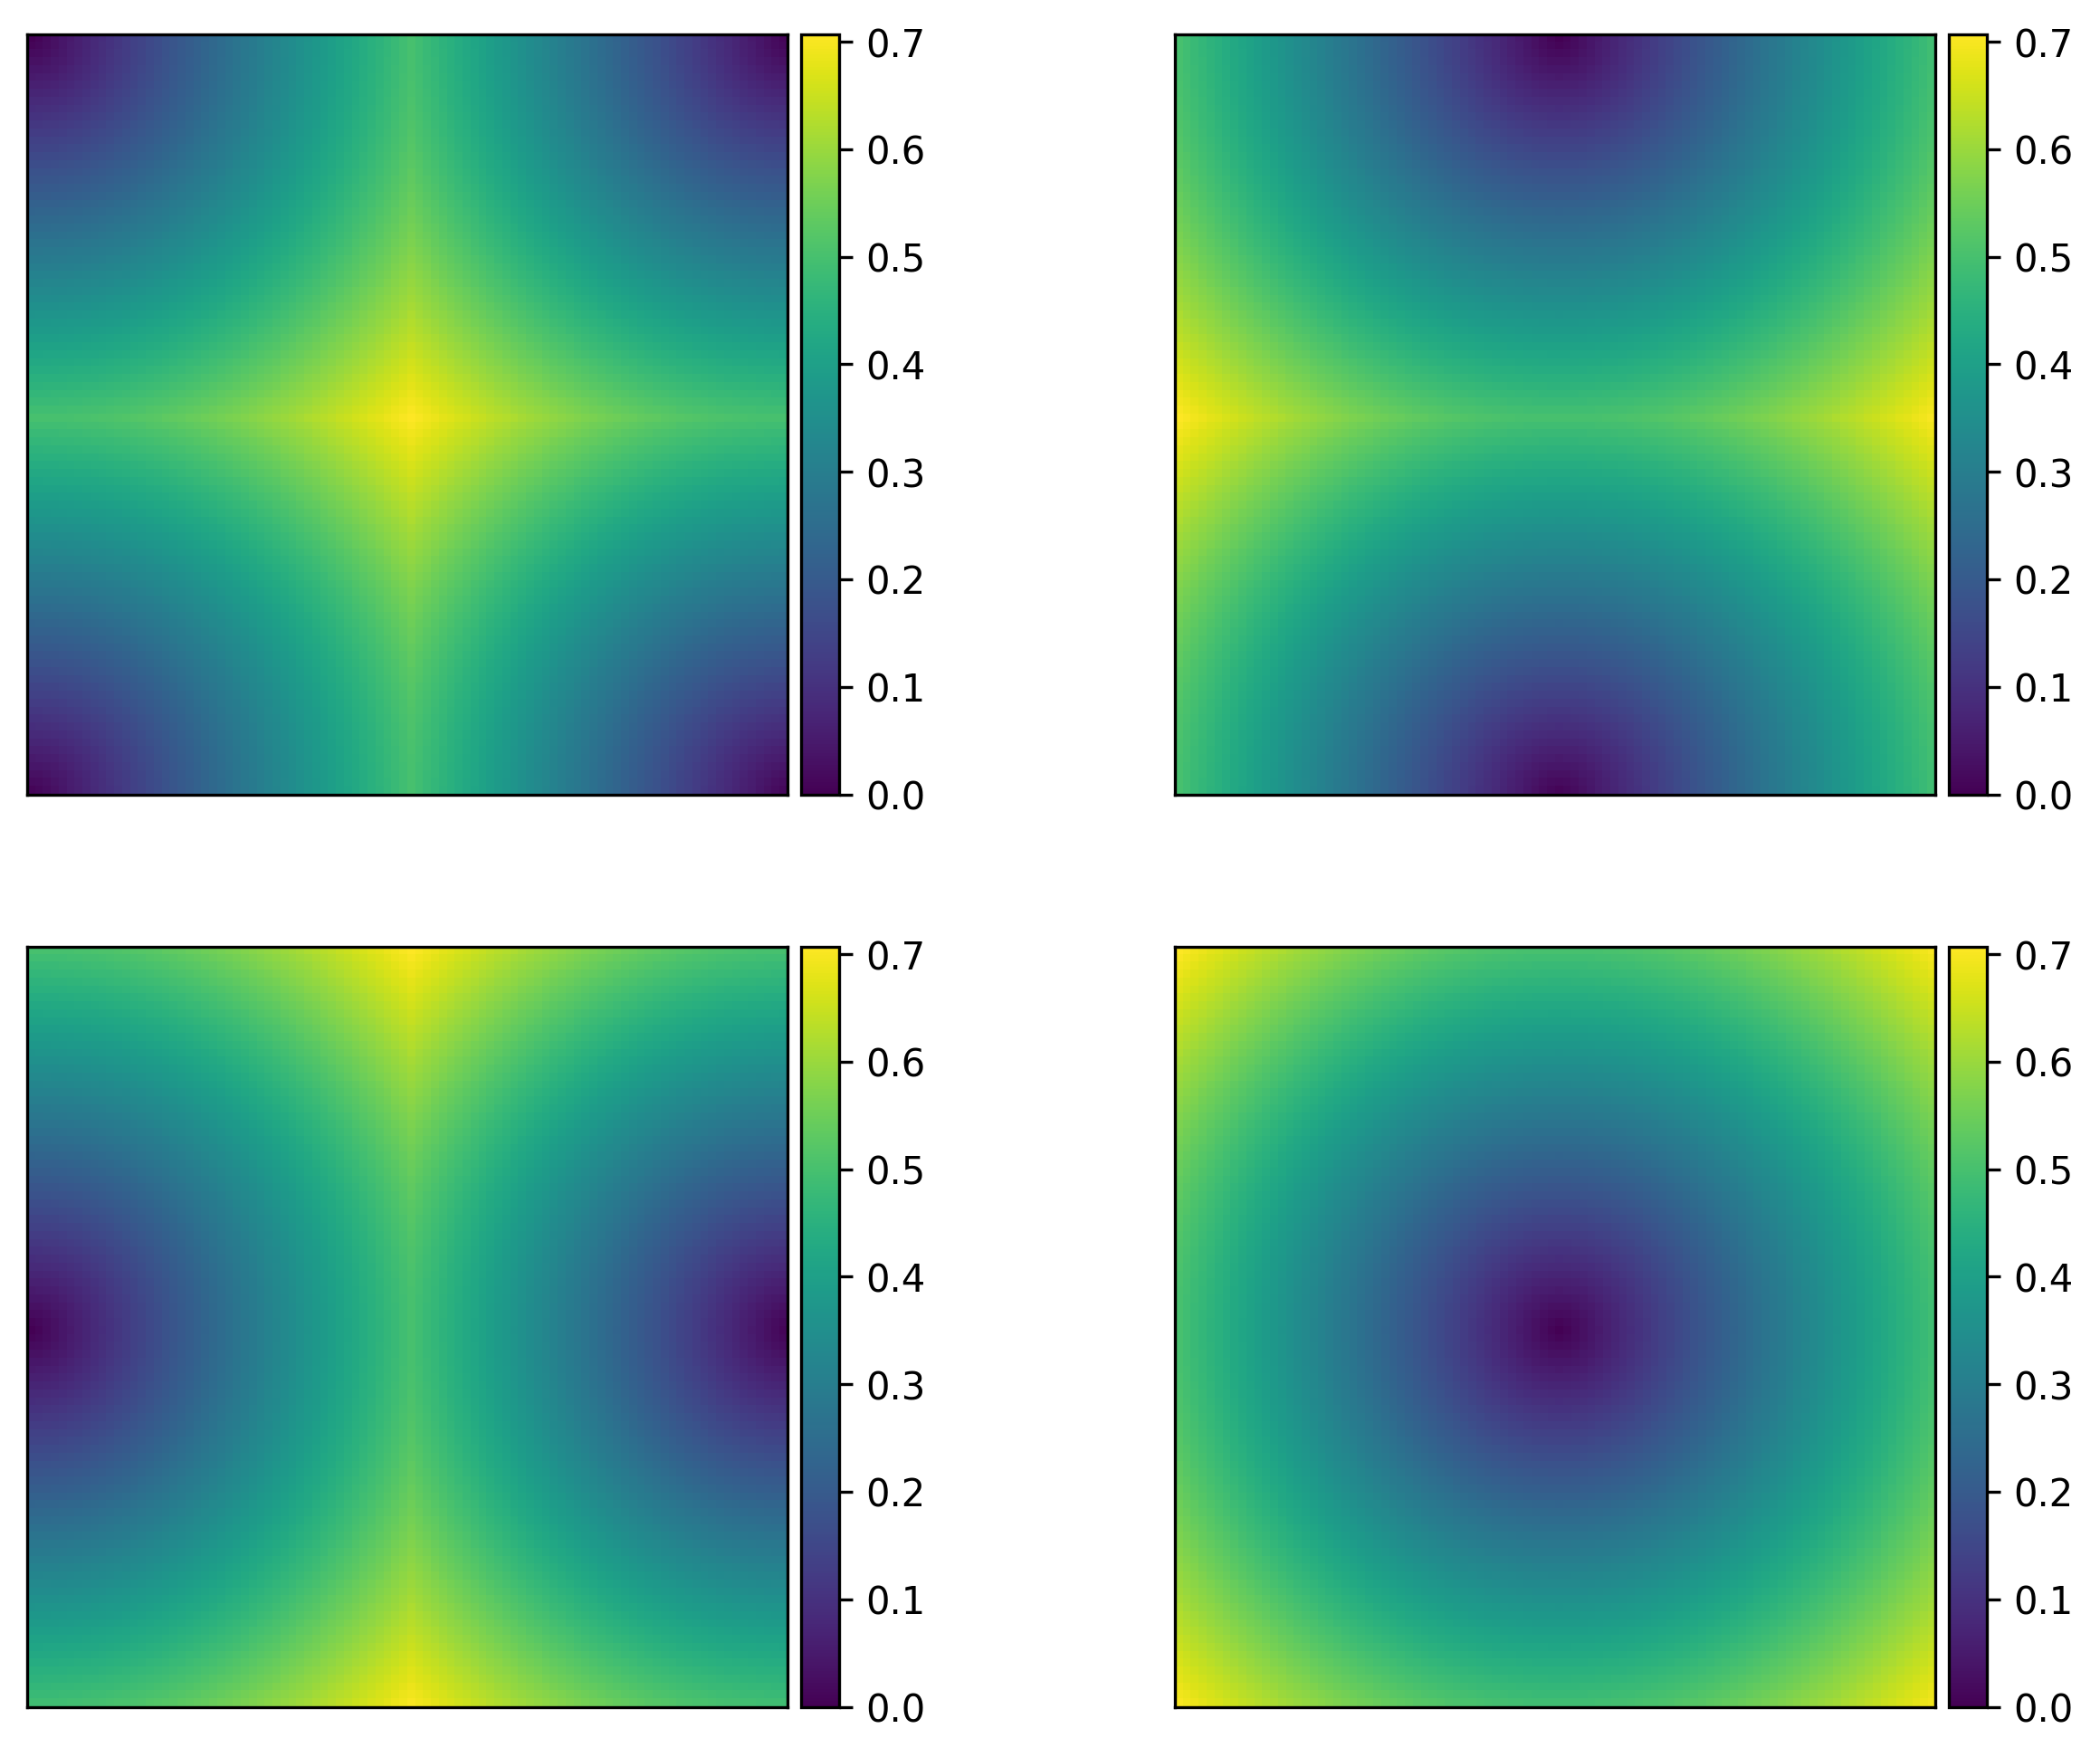

In [5]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0,0],ds.reshape(N,N,N,N)[0,0,:,:],cmap='viridis')
pf.imshowbar(fig,axs[0,1],ds.reshape(N,N,N,N)[0,N//2,:,:],cmap='viridis')
pf.imshowbar(fig,axs[1,0],ds.reshape(N,N,N,N)[N//2,0,:,:],cmap='viridis')
pf.imshowbar(fig,axs[1,1],ds.reshape(N,N,N,N)[N//2,N//2,:,:],cmap='viridis')

# Look at Stevens et al LGN Input with IID Retinal Activity

## Build Ret$\to$LGN Connectivity

In [6]:
conn_params = {
    'sigma1':  0.037,
    'sigma2':  0.15,
    'ampl1':   1.0,
    'ampl2':   1.0,
    'noise':   0.0,
    'profile': 'Mexican-hat',
    'stevensetal': True
}

In [7]:
reload(connectivity)

conn = connectivity.Connectivity((N,N),(N,N),0)
WRtoT,_ = conn.create_matrix(conn_params,conn_params['profile'])

In [8]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

WRtoT_d = np.zeros(72)

for idx in range(72):
    WRtoT_d[idx] = np.mean(WRtoT[bin_idxs == idx])

Text(0.5, 1.0, 'Sum of Presynaptic Weights')

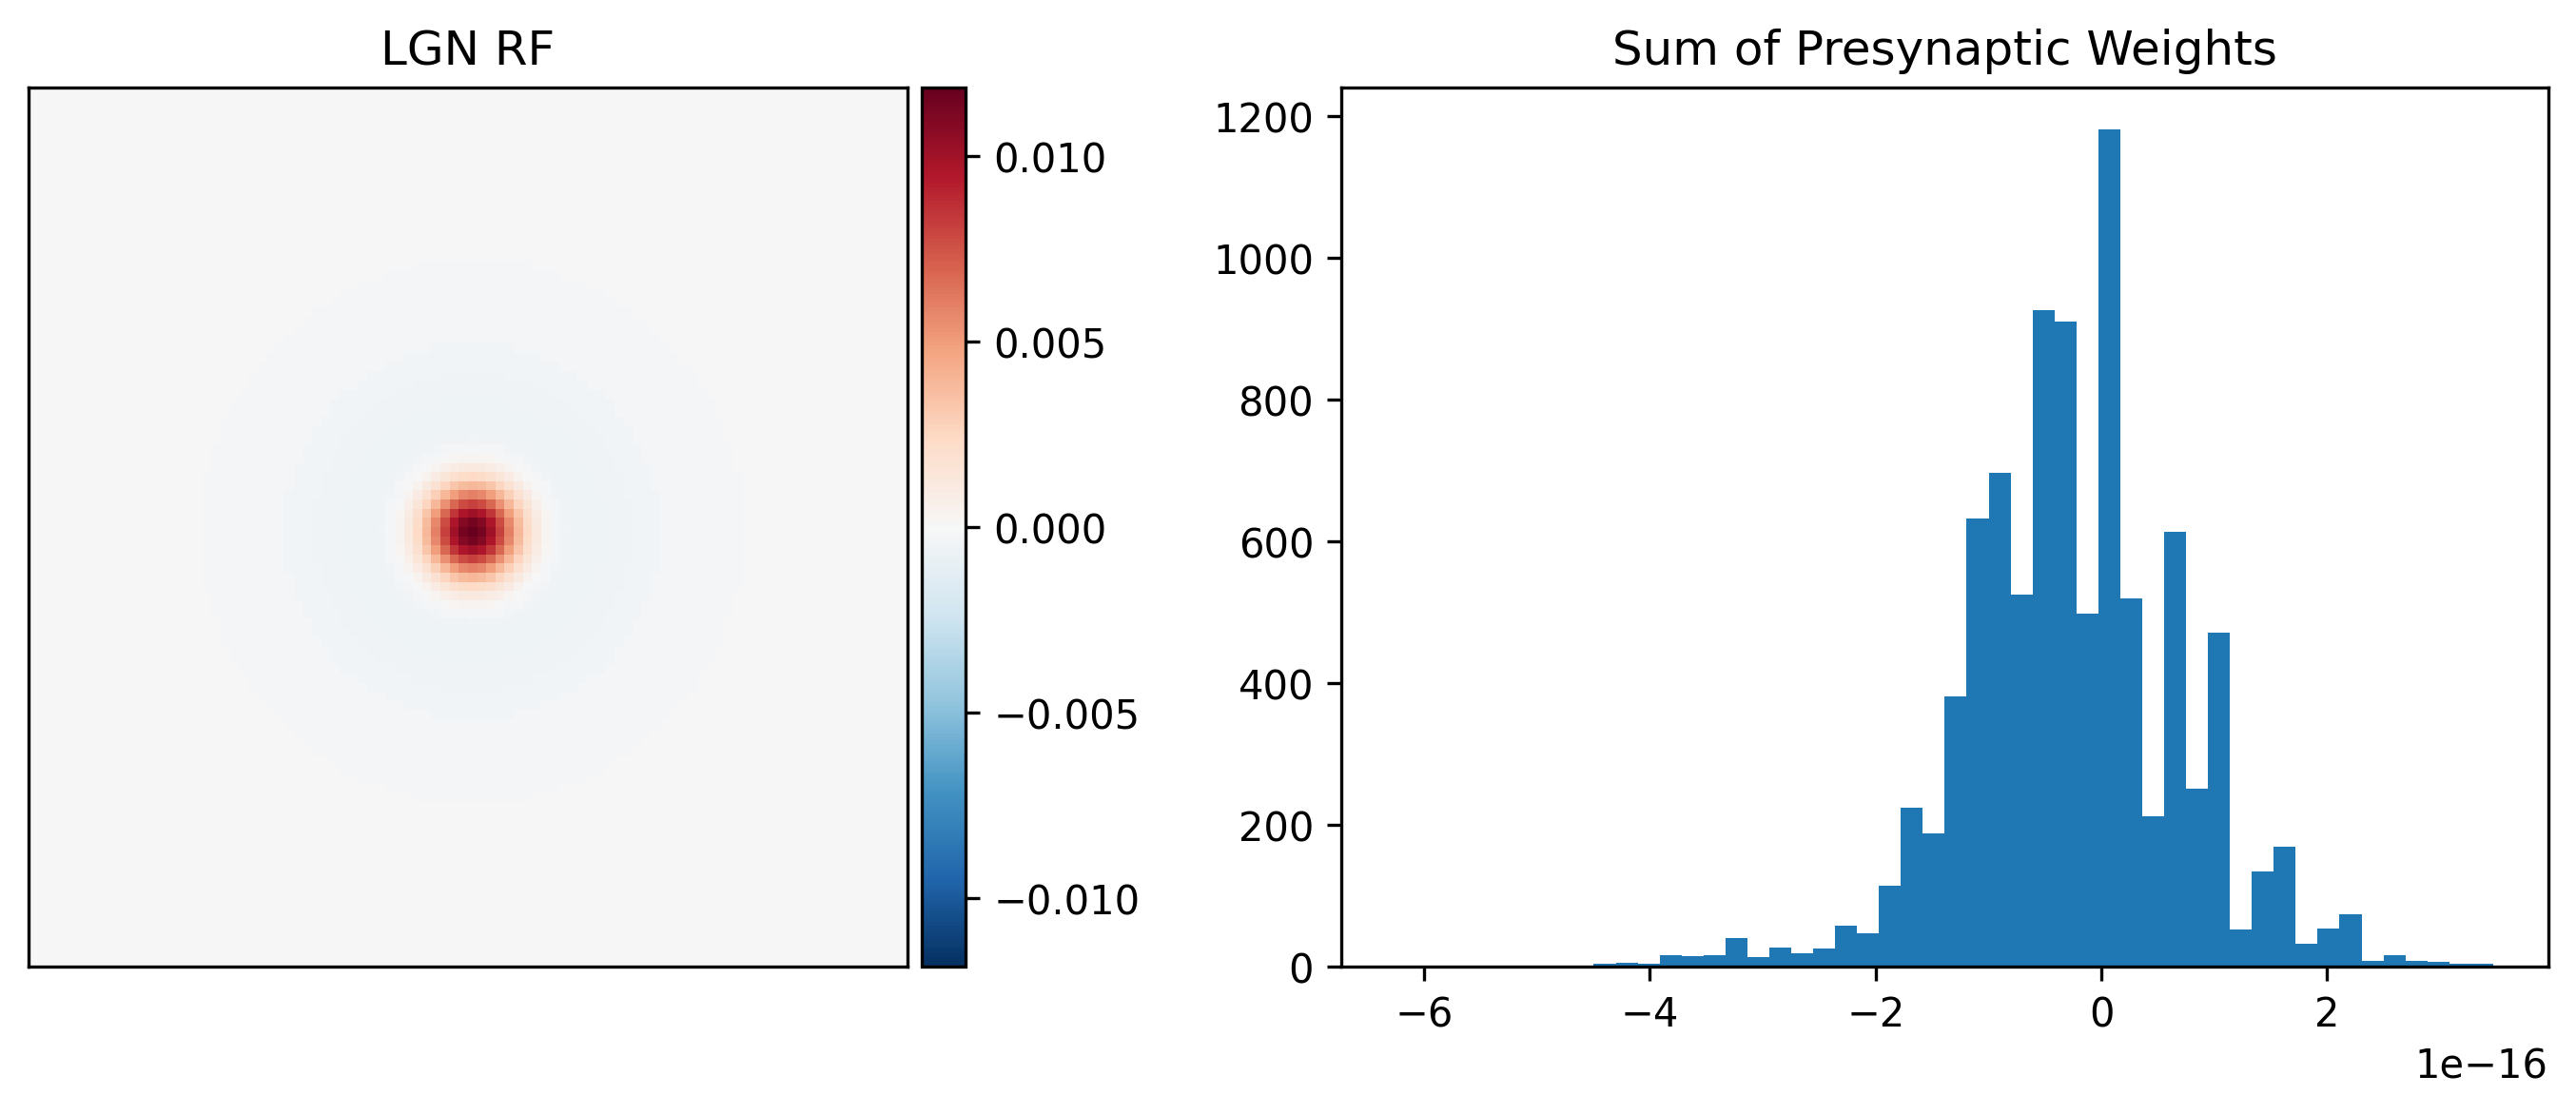

In [9]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0],WRtoT.reshape(N,N,N,N)[N//2,N//2,:,:],
          vmin=-np.max(np.abs(WRtoT)),vmax=np.max(np.abs(WRtoT)))

axs[1].hist(np.sum(WRtoT,1),50)

axs[0].set_title('LGN RF')
axs[1].set_title('Sum of Presynaptic Weights')

## Create Retinal Activity Patterns

In [10]:
n_ret_patts = 1000
unif_psis = np.random.default_rng(0).random(size=(n_ret_patts,Nret**2))
norm_psis = np.random.default_rng(0).normal(size=(n_ret_patts,Nret**2))

In [11]:
unif_Wpsis = np.einsum('ij,kj->ki',WRtoT,unif_psis)
norm_Wpsis = np.einsum('ij,kj->ki',WRtoT,norm_psis)

Text(0.5, 1.0, 'Input to LGN Histogram')

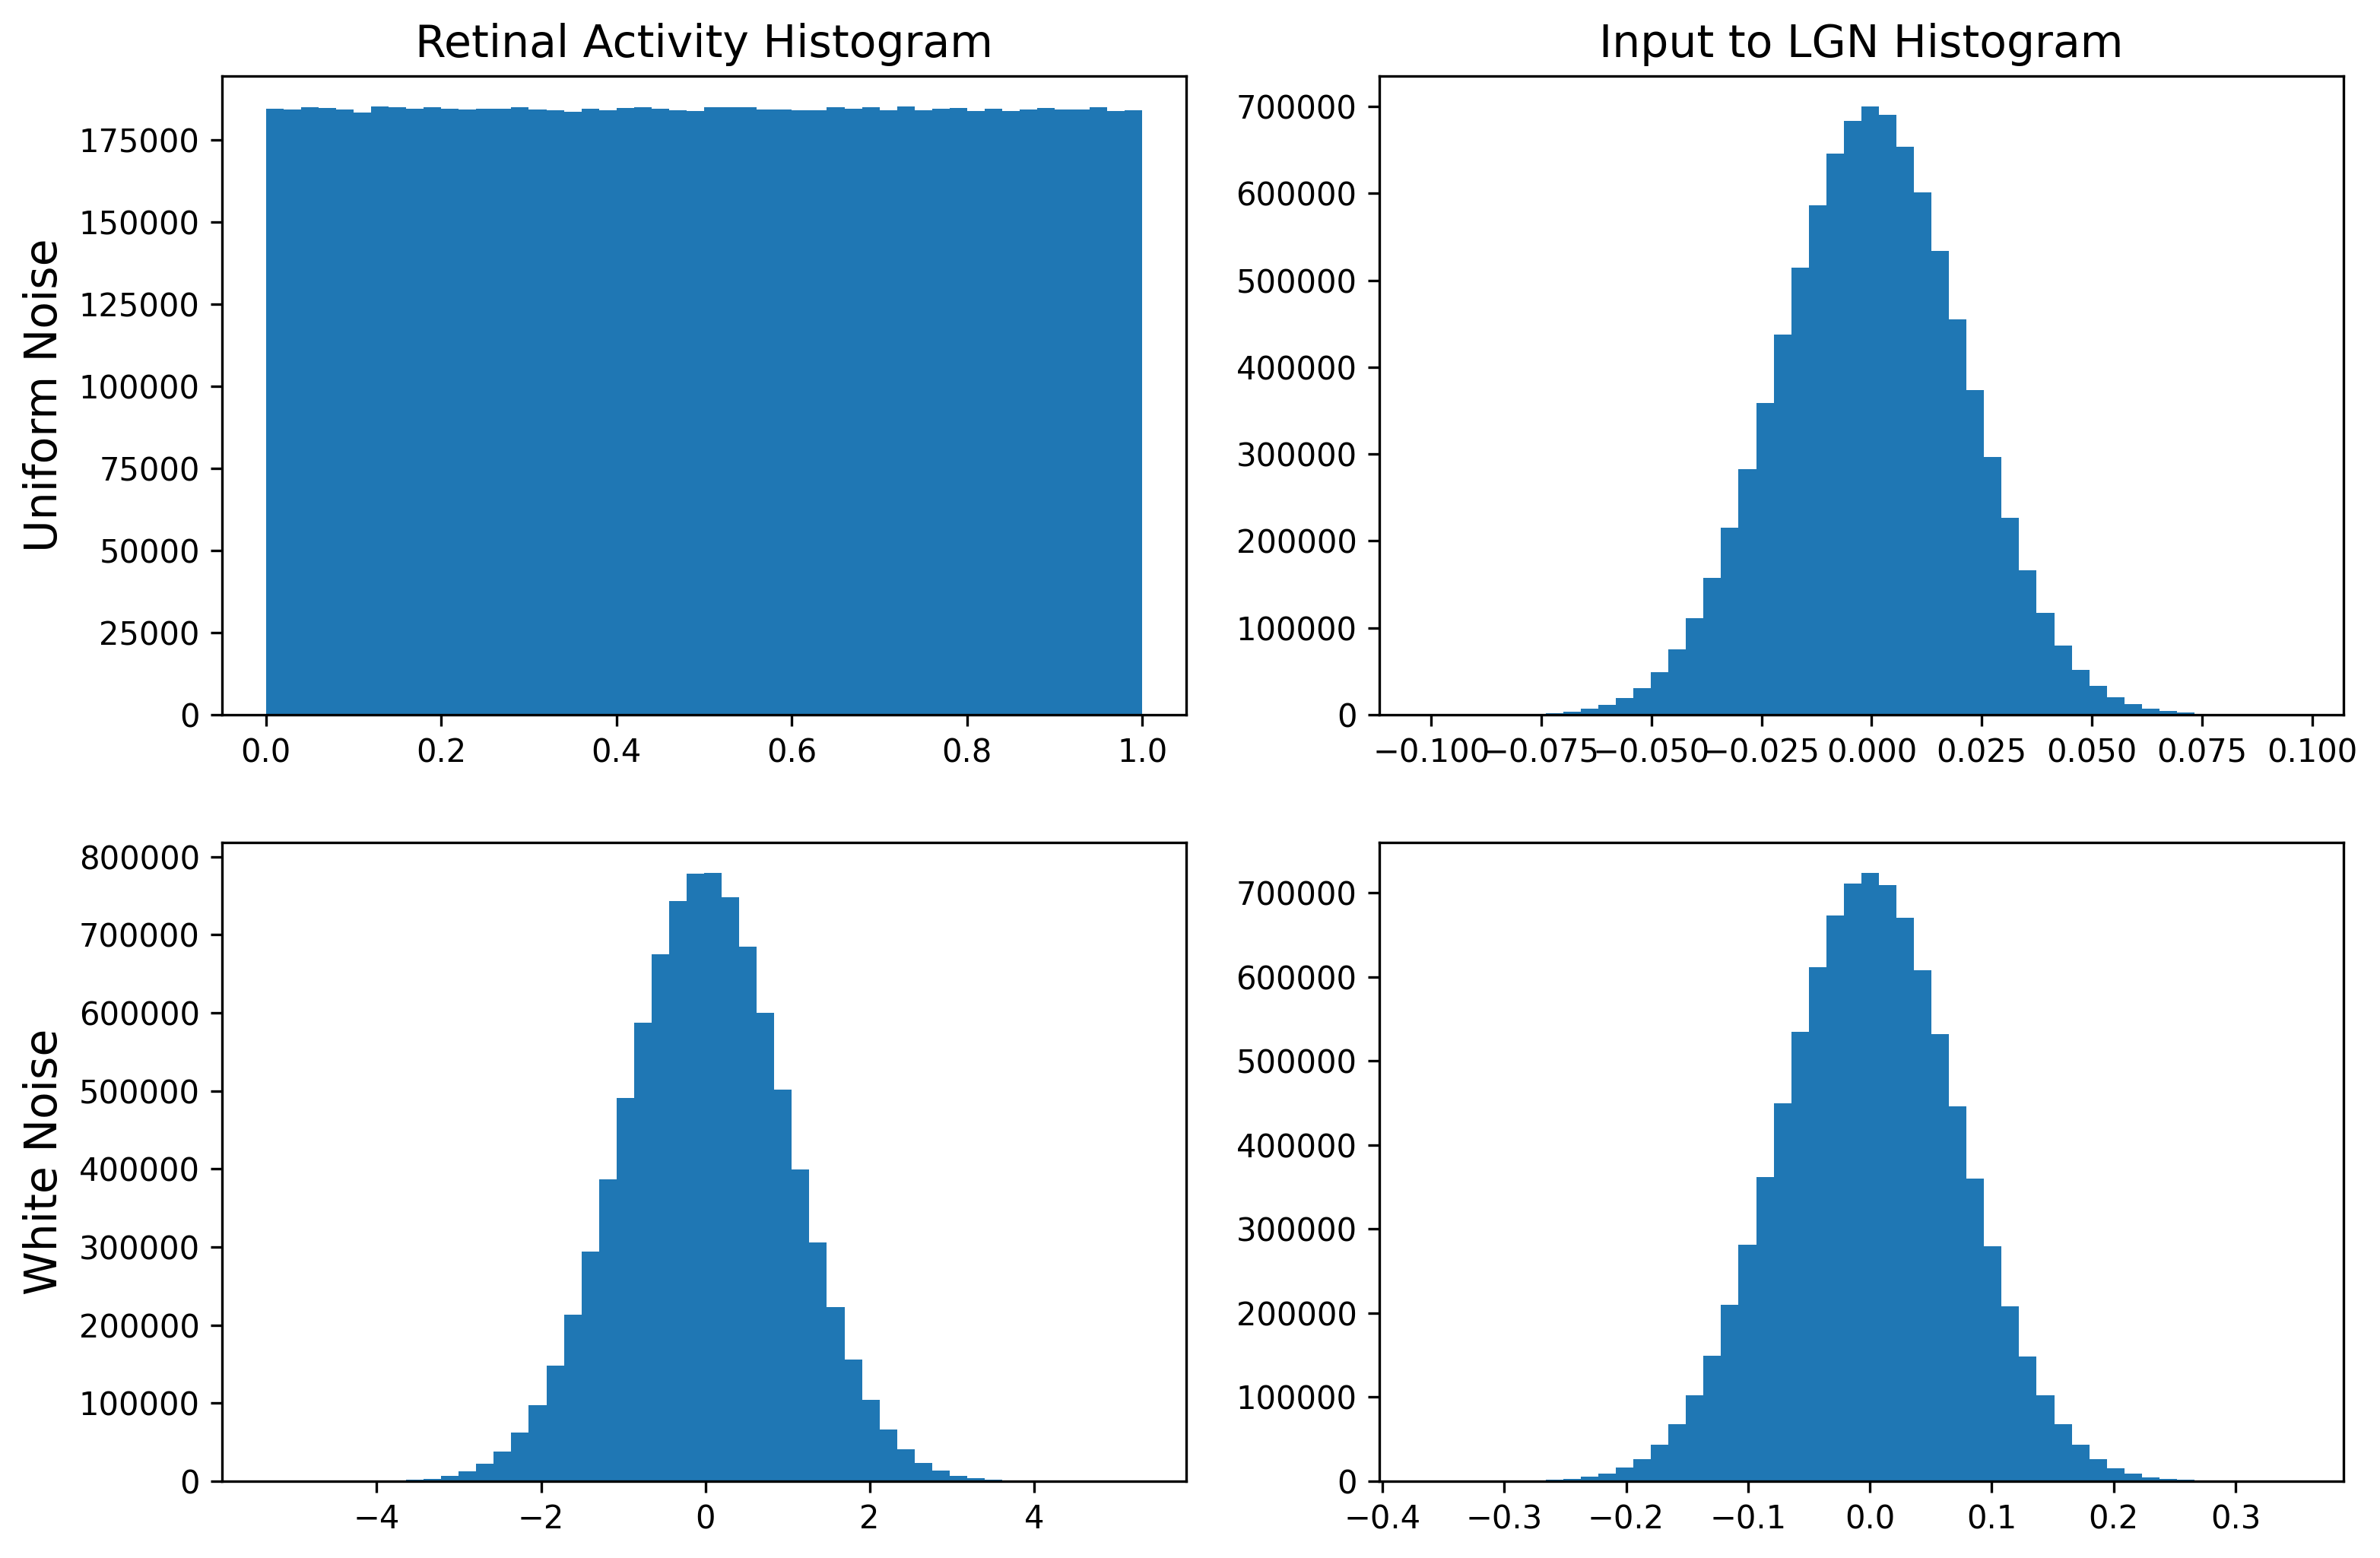

In [12]:
fig,axs = plt.subplots(2,2,figsize=(12,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0,0].hist(unif_psis.flatten(),50)
axs[0,1].hist(unif_Wpsis.flatten(),50)
axs[1,0].hist(norm_psis.flatten(),50)
axs[1,1].hist(norm_Wpsis.flatten(),50)

axs[0,0].set_ylabel('Uniform Noise',fontsize=14)
axs[1,0].set_ylabel('White Noise',fontsize=14)
axs[0,0].set_title('Retinal Activity Histogram',fontsize=14)
axs[0,1].set_title('Input to LGN Histogram',fontsize=14)

In [13]:
print(np.std(unif_Wpsis.flatten()))
print(np.std(norm_Wpsis.flatten()))

0.020842153439384392
0.07259555280647194


## Create LGN Activity Patterns

In [14]:
unif_N_act = fio_rect(14*unif_Wpsis)
unif_F_act = fio_rect(14*-unif_Wpsis)

norm_N_act = fio_rect(4*norm_Wpsis)
norm_F_act = fio_rect(4*-norm_Wpsis)

Text(0.5, 1.0, 'Off Cell Activity Histogram')

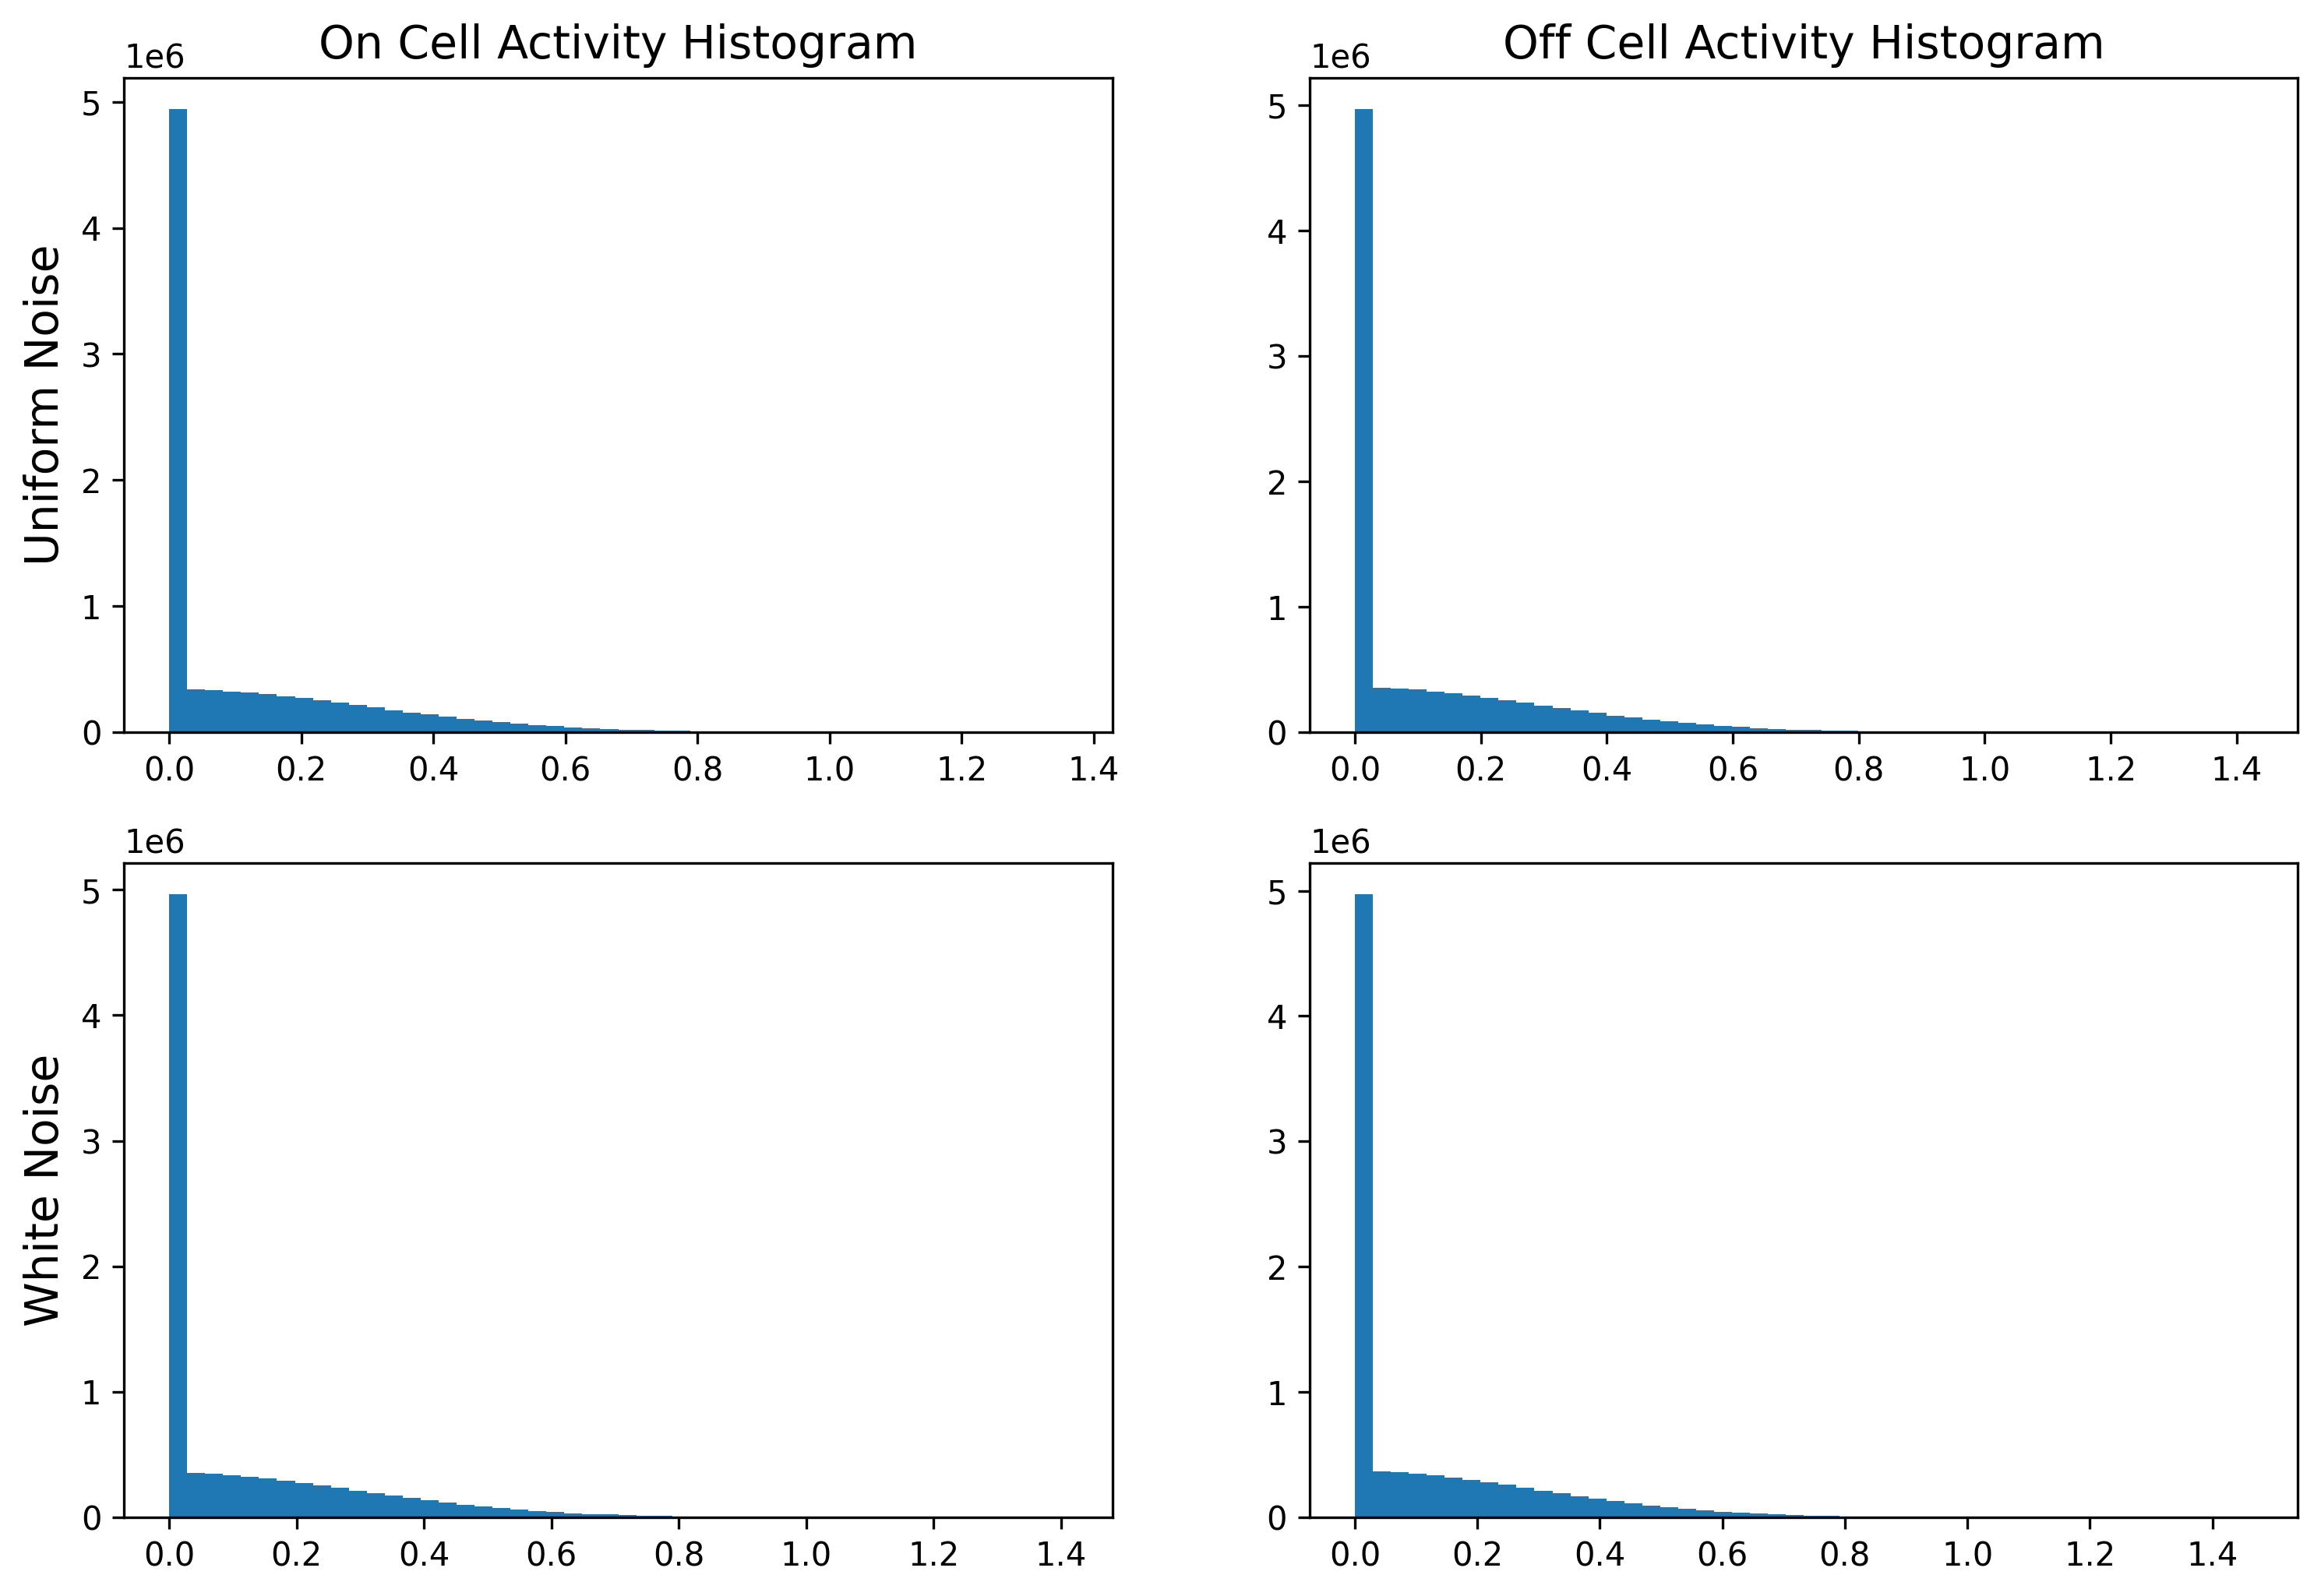

In [15]:
fig,axs = plt.subplots(2,2,figsize=(12,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0,0].hist(unif_N_act.flatten(),50)
axs[0,1].hist(unif_F_act.flatten(),50)
axs[1,0].hist(norm_N_act.flatten(),50)
axs[1,1].hist(norm_F_act.flatten(),50)

axs[0,0].set_ylabel('Uniform Noise',fontsize=14)
axs[1,0].set_ylabel('White Noise',fontsize=14)
axs[0,0].set_title('On Cell Activity Histogram',fontsize=14)
axs[0,1].set_title('Off Cell Activity Histogram',fontsize=14)

## Calculate Spatial Correlations

In [16]:
unif_full_cov = np.cov(unif_N_act.T,unif_F_act.T)
unif_NN_cov = unif_full_cov[:N**2,:N**2]
unif_NF_cov = unif_full_cov[:N**2,N**2:]
unif_FN_cov = unif_full_cov[N**2:,:N**2]
unif_FF_cov = unif_full_cov[N**2:,N**2:]

norm_full_cov = np.cov(norm_N_act.T,norm_F_act.T)
norm_NN_cov = norm_full_cov[:N**2,:N**2]
norm_NF_cov = norm_full_cov[:N**2,N**2:]
norm_FN_cov = norm_full_cov[N**2:,:N**2]
norm_FF_cov = norm_full_cov[N**2:,N**2:]

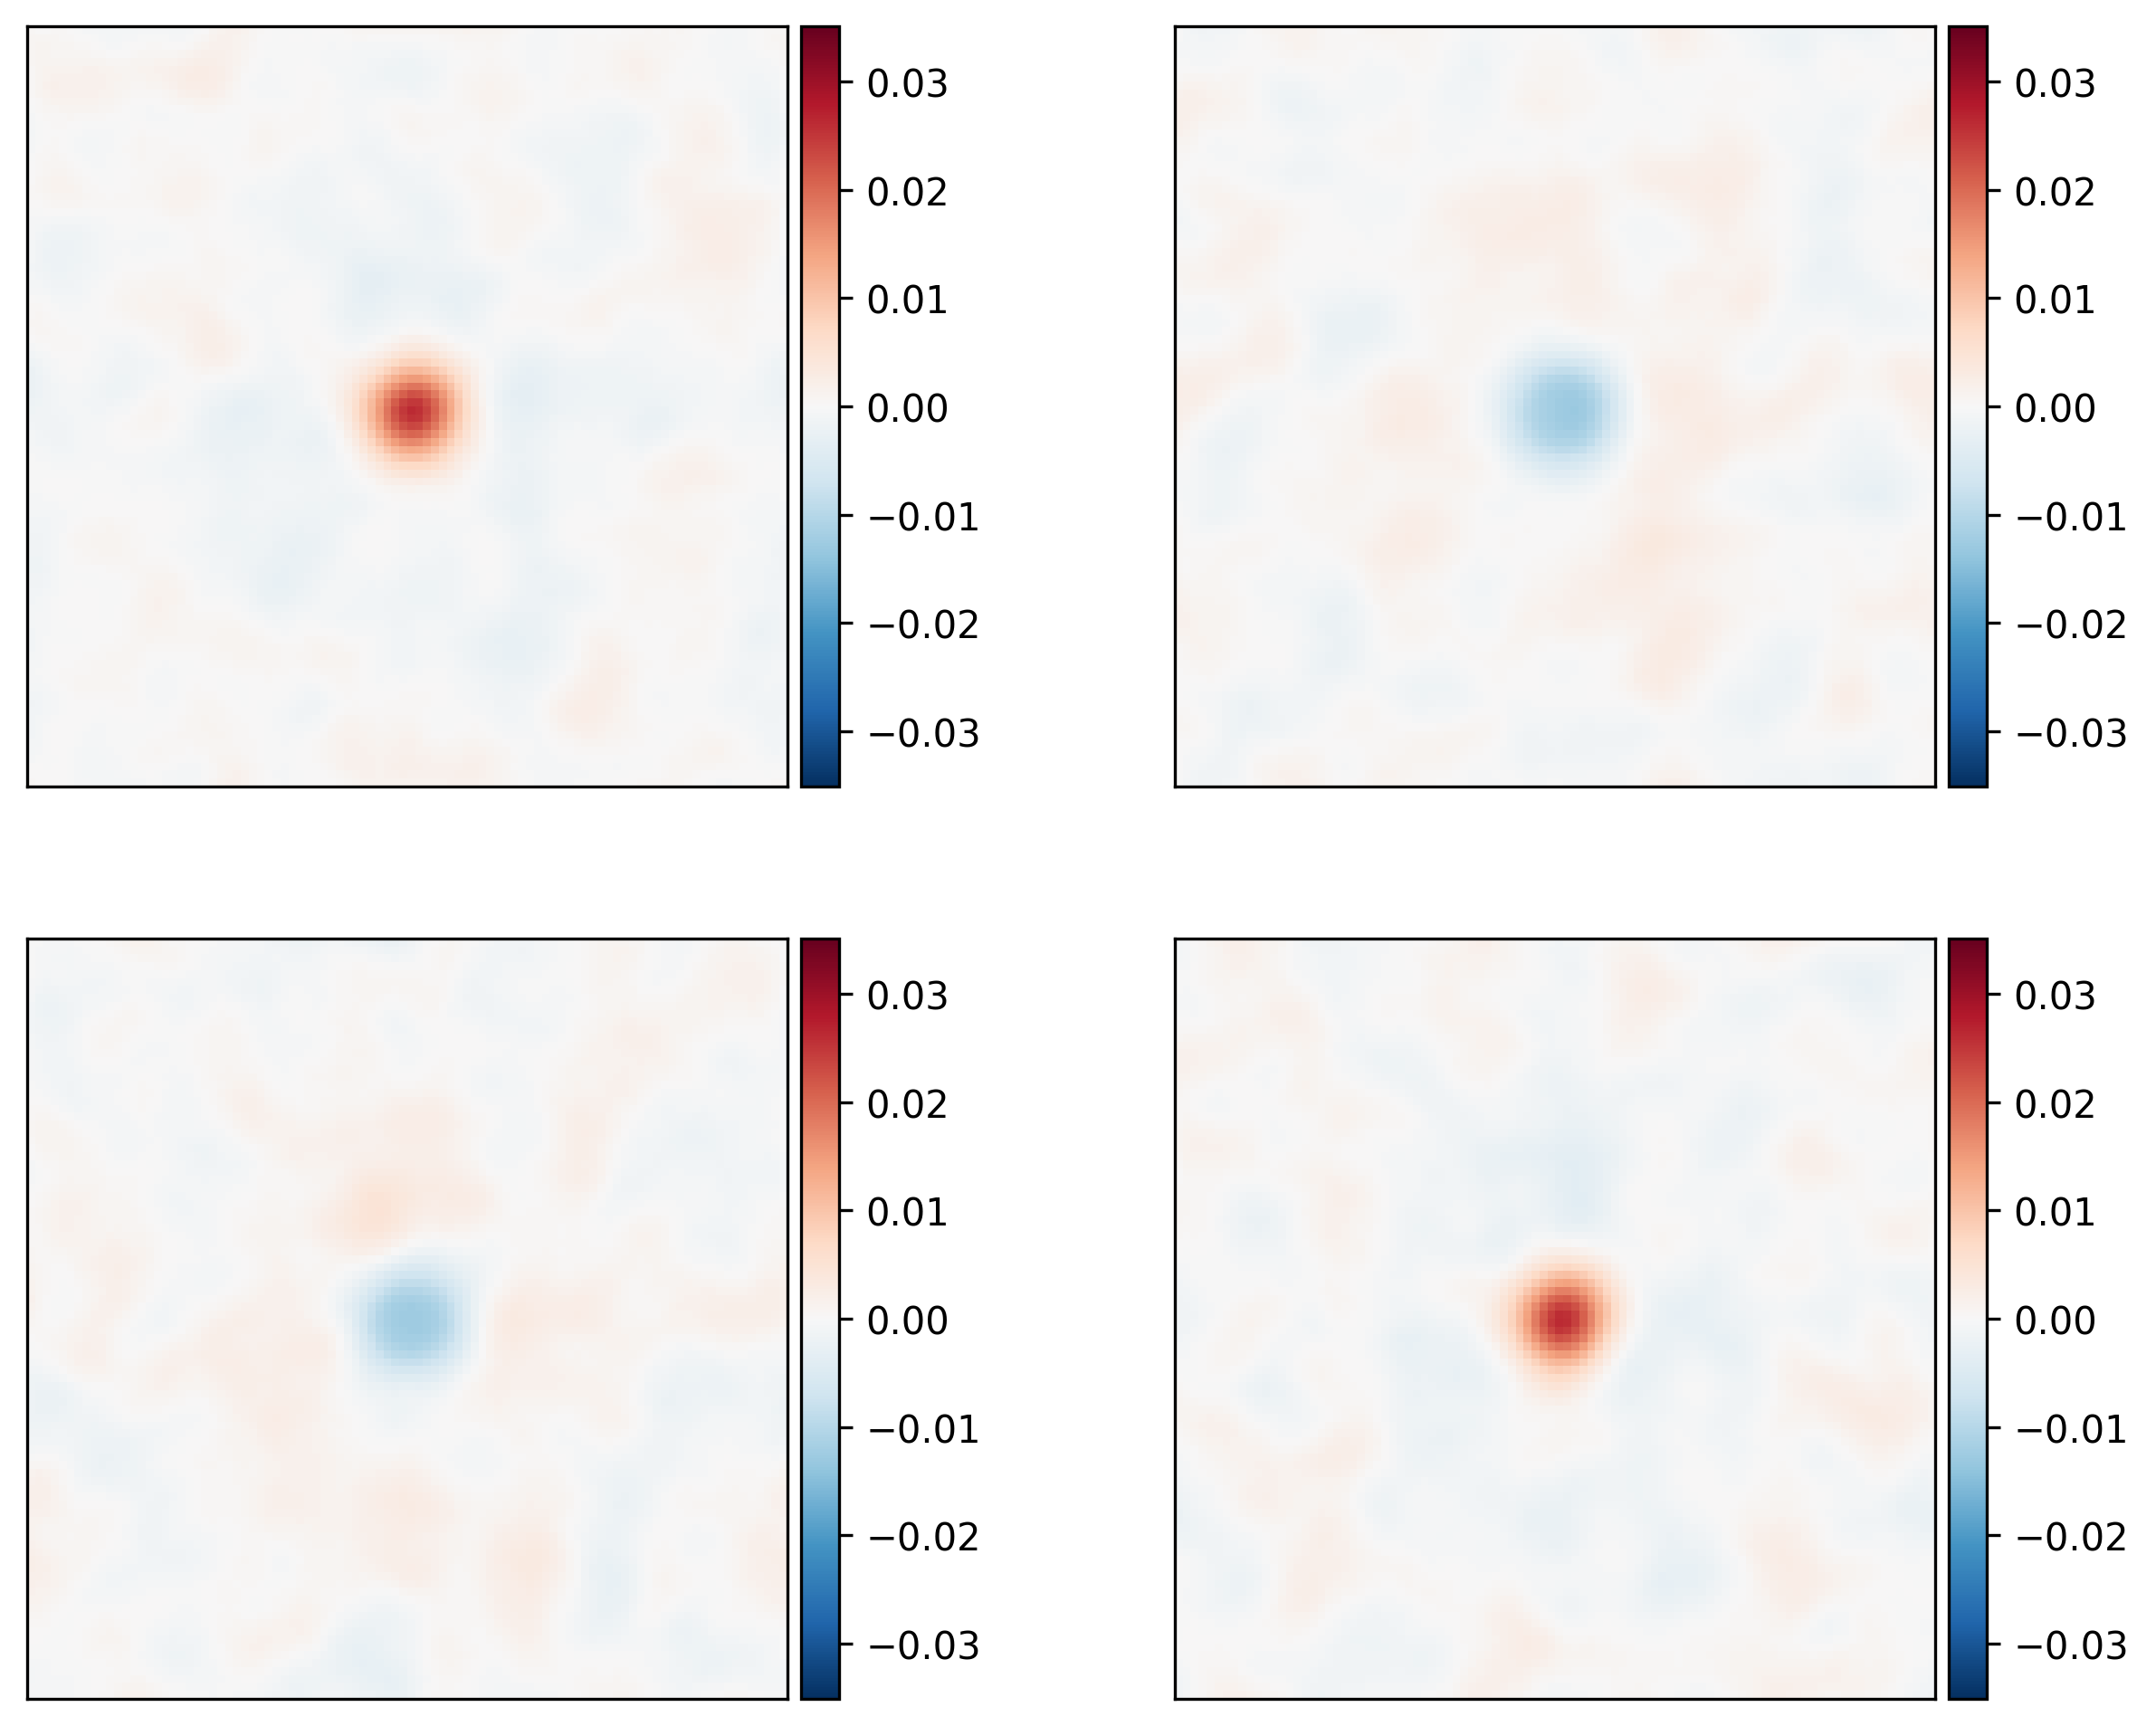

In [17]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

lim = np.max(np.abs(norm_full_cov))

pf.imshowbar(fig,axs[0,0],norm_NN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[0,1],norm_NF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[1,0],norm_FN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[1,1],norm_FF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)

In [18]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

norm_S_cov = np.zeros(72)
norm_S_cov_err = np.zeros(72)
norm_D_cov = np.zeros(72)
norm_D_cov_err = np.zeros(72)

for idx in range(72):
    norm_S_cov[idx] = 0.5*(np.mean(norm_NN_cov[bin_idxs == idx]) + np.mean(norm_FF_cov[bin_idxs == idx]))
    norm_S_cov_err[idx] = np.sqrt(np.var(norm_NN_cov[bin_idxs == idx]) + np.var(norm_FF_cov[bin_idxs == idx]))
    norm_D_cov[idx] = 0.5*(np.mean(norm_NF_cov[bin_idxs == idx]) + np.mean(norm_NF_cov[bin_idxs == idx]))
    norm_D_cov_err[idx] = np.sqrt(np.var(norm_NF_cov[bin_idxs == idx]) + np.var(norm_NF_cov[bin_idxs == idx]))

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance')

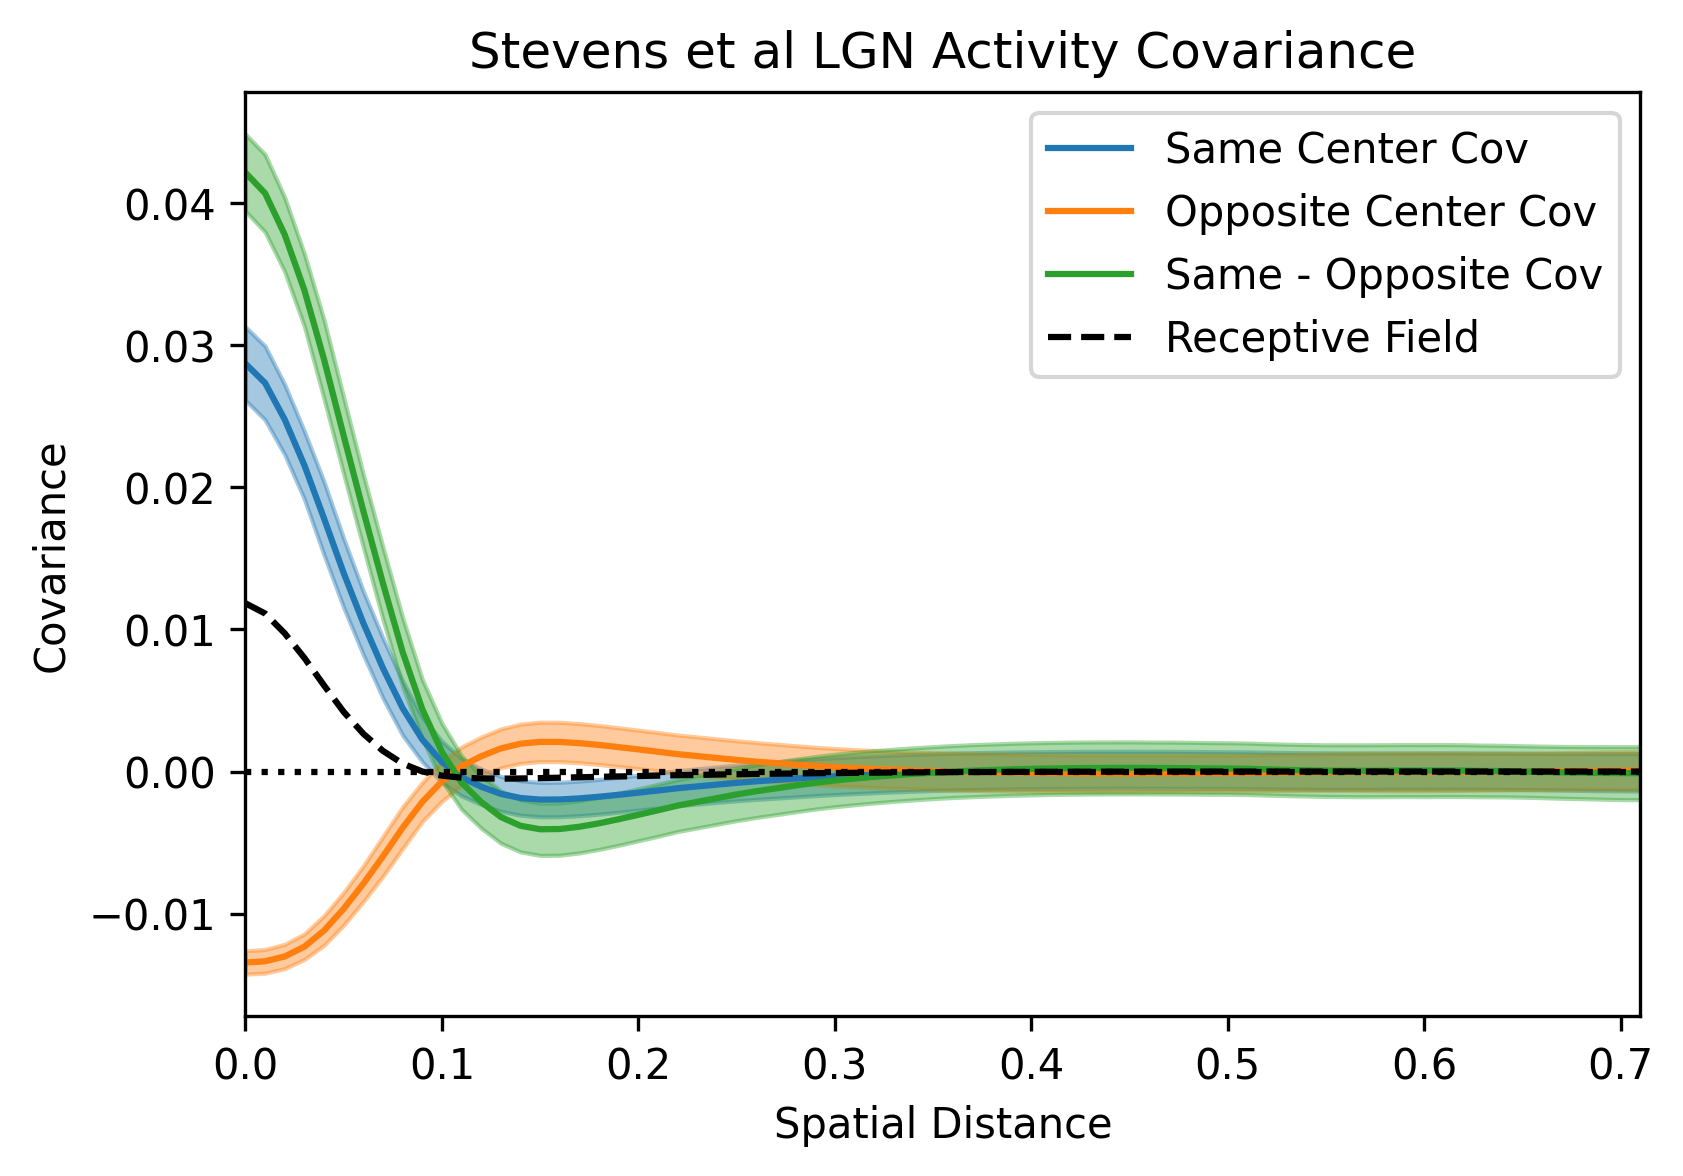

In [19]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,norm_S_cov,c='C0',label='Same Center Cov')
axs.fill_between(dists,norm_S_cov-norm_S_cov_err,norm_S_cov+norm_S_cov_err,color='C0',alpha=0.4)
axs.plot(dists,norm_D_cov,c='C1',label='Opposite Center Cov')
axs.fill_between(dists,norm_D_cov-norm_D_cov_err,norm_D_cov+norm_D_cov_err,color='C1',alpha=0.4)
axs.plot(dists,norm_S_cov-norm_D_cov,c='C2',label='Same - Opposite Cov')
axs.fill_between(dists,norm_S_cov-norm_D_cov-np.sqrt(norm_S_cov_err**2+norm_D_cov_err**2),
                 norm_S_cov-norm_D_cov+np.sqrt(norm_S_cov_err**2+norm_D_cov_err**2),color='C2',alpha=0.4)
axs.plot(dists,WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Stevens et al LGN Activity Covariance')

# Look at Bettina Model's LGN Input with Different On/Off Input

## Create LGN Activity Patterns

In [20]:
inp_params = {
    'onoff_corr_factor': 1.0,
    'input_type': 'white_noise_rect'
}

In [23]:
reload(inputs)

inp = inputs.Inputs_lgn((N,N),0,0)
lgn = inp.create_lgn_input(inp_params,inp_params['input_type'],WRtoT,expansion_timestep=0).numpy()

Text(0.5, 1.0, 'Input to LGN Histogram')

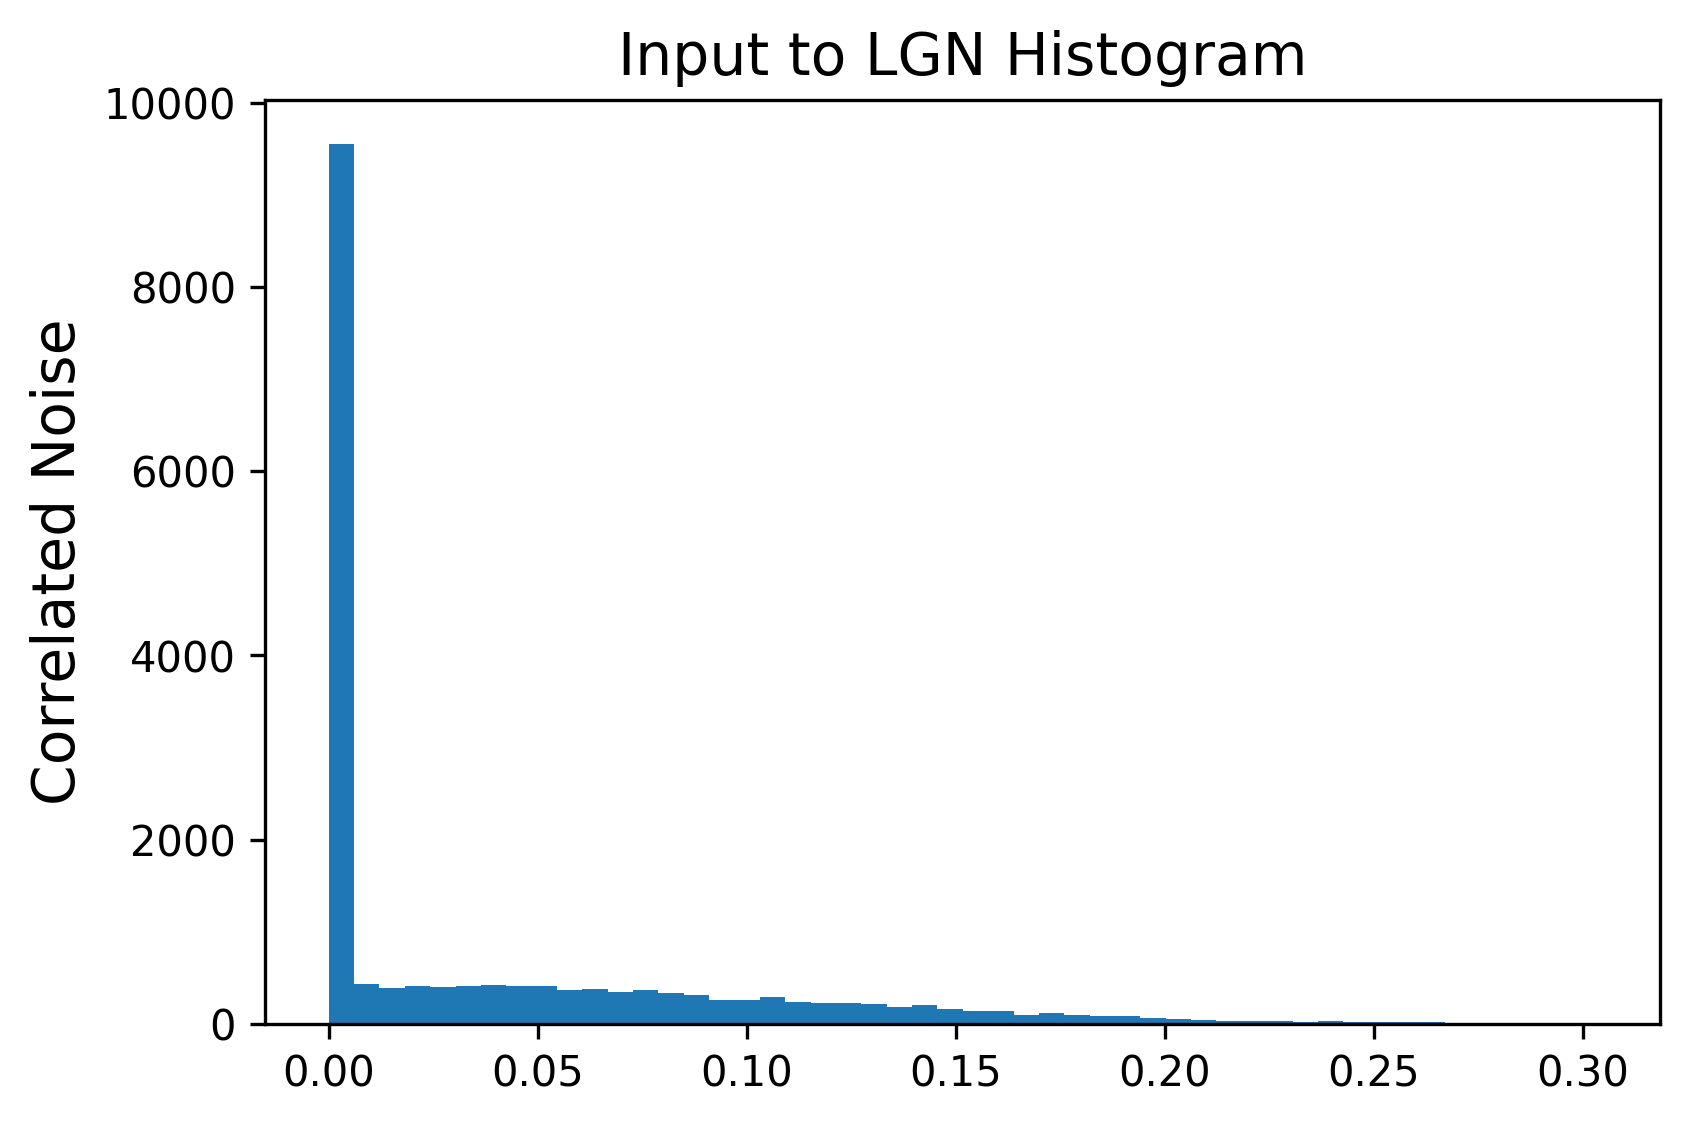

In [24]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.hist(lgn.flatten(),50)

axs.set_ylabel('Correlated Noise',fontsize=14)
axs.set_title('Input to LGN Histogram',fontsize=14)

In [25]:
np.std(lgn)

0.058753185

In [26]:
n_ret_patts = 1000

bett_N_act = np.zeros((n_ret_patts,N**2))
bett_F_act = np.zeros((n_ret_patts,N**2))

for i in range(n_ret_patts):
    lgn = inp.create_lgn_input(inp_params,inp_params['input_type'],WRtoT,expansion_timestep=0)
    bett_N_act[i] = 3*lgn[0]
    bett_F_act[i] = 3*lgn[1]

Text(0.5, 1.0, 'Off Cell Activity Histogram')

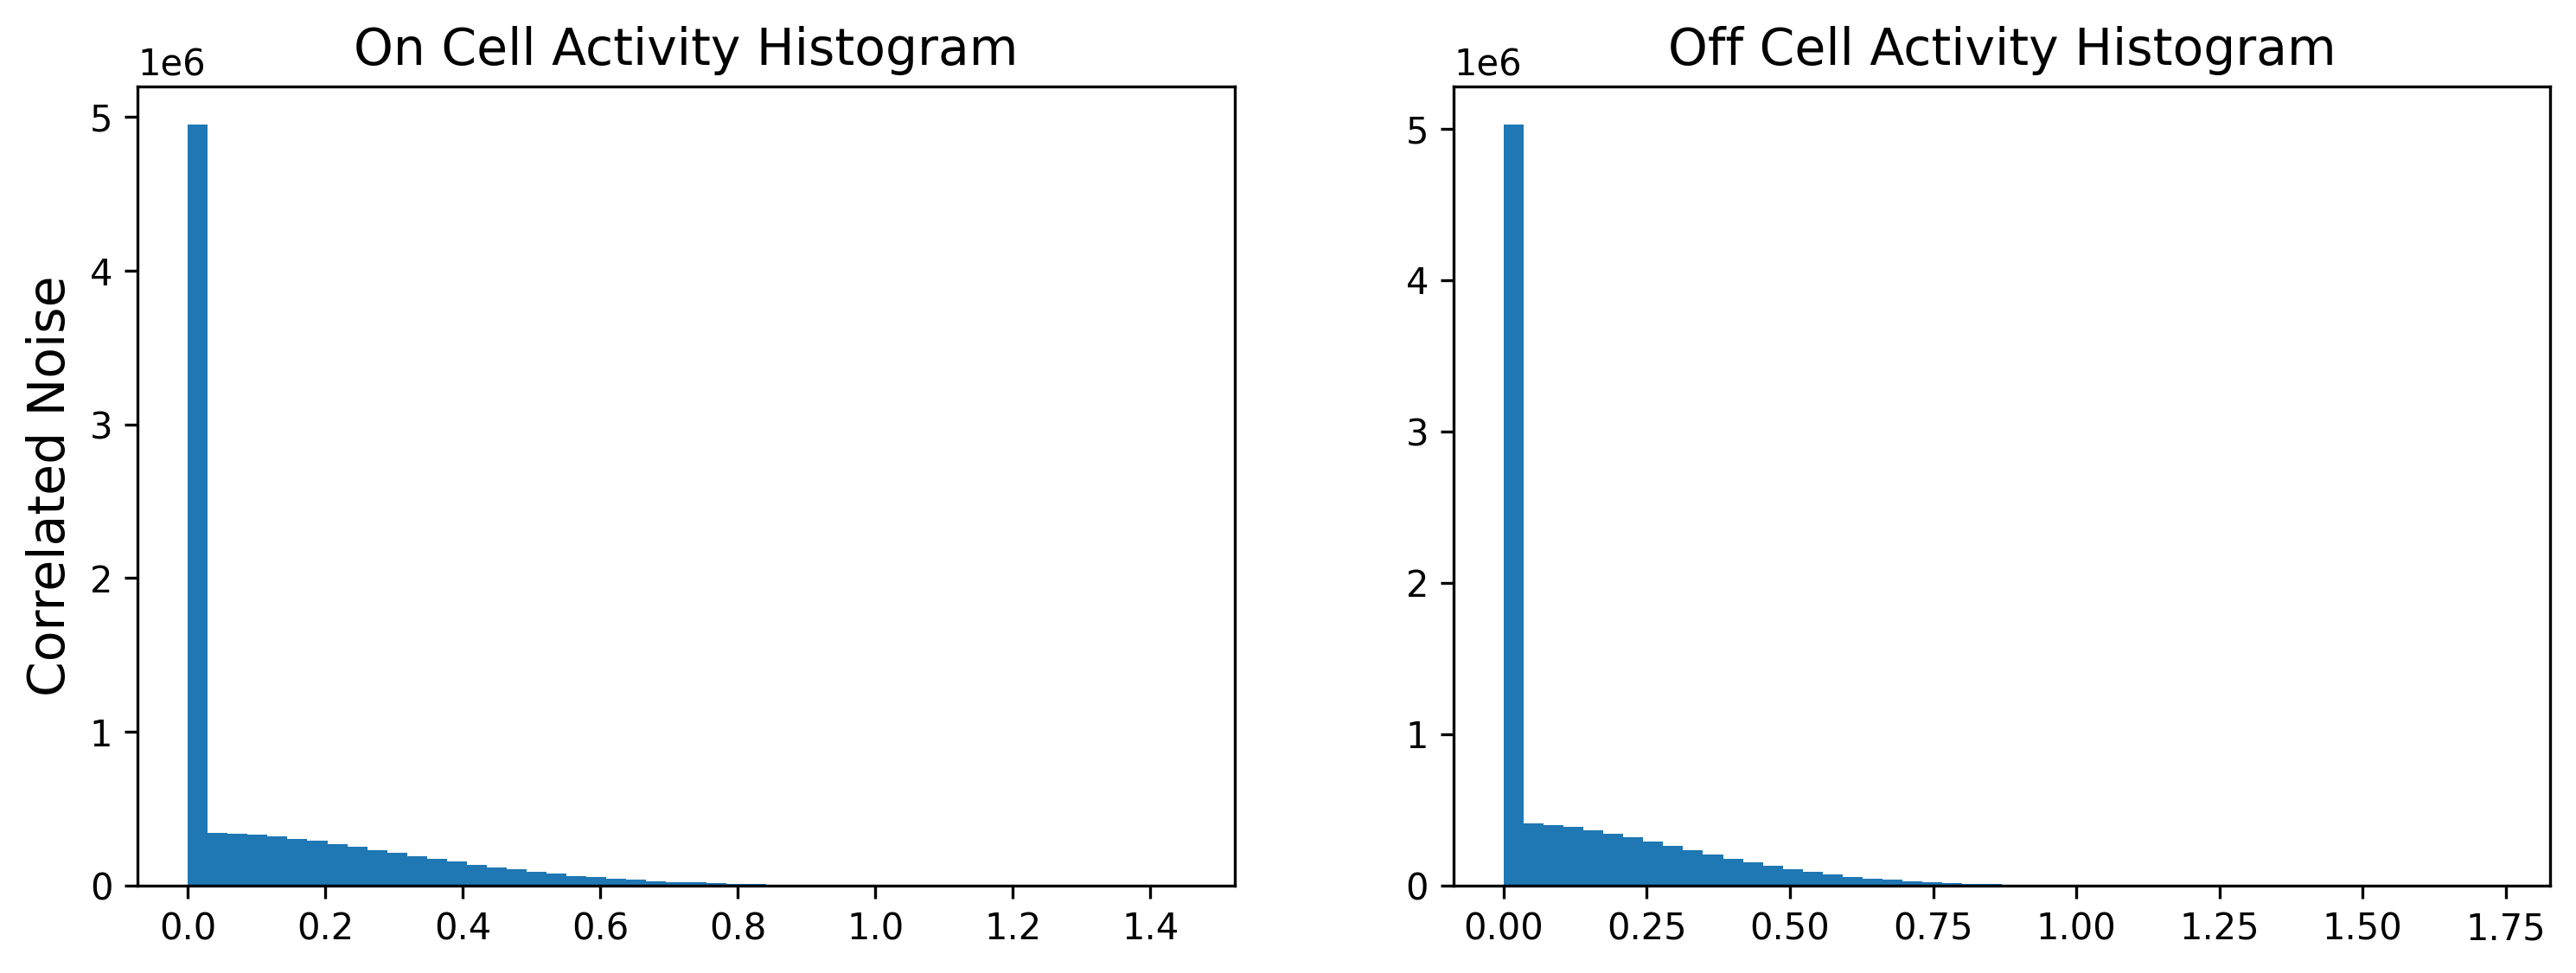

In [27]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].hist(bett_N_act.flatten(),50)
axs[1].hist(bett_F_act.flatten(),50)

axs[0].set_ylabel('Correlated Noise',fontsize=14)
axs[0].set_title('On Cell Activity Histogram',fontsize=14)
axs[1].set_title('Off Cell Activity Histogram',fontsize=14)

## Calculate Spatial Correlations

In [28]:
bett_full_cov = np.cov(bett_N_act.T,bett_F_act.T)
bett_NN_cov = bett_full_cov[:N**2,:N**2]
bett_NF_cov = bett_full_cov[:N**2,N**2:]
bett_FN_cov = bett_full_cov[N**2:,:N**2]
bett_FF_cov = bett_full_cov[N**2:,N**2:]

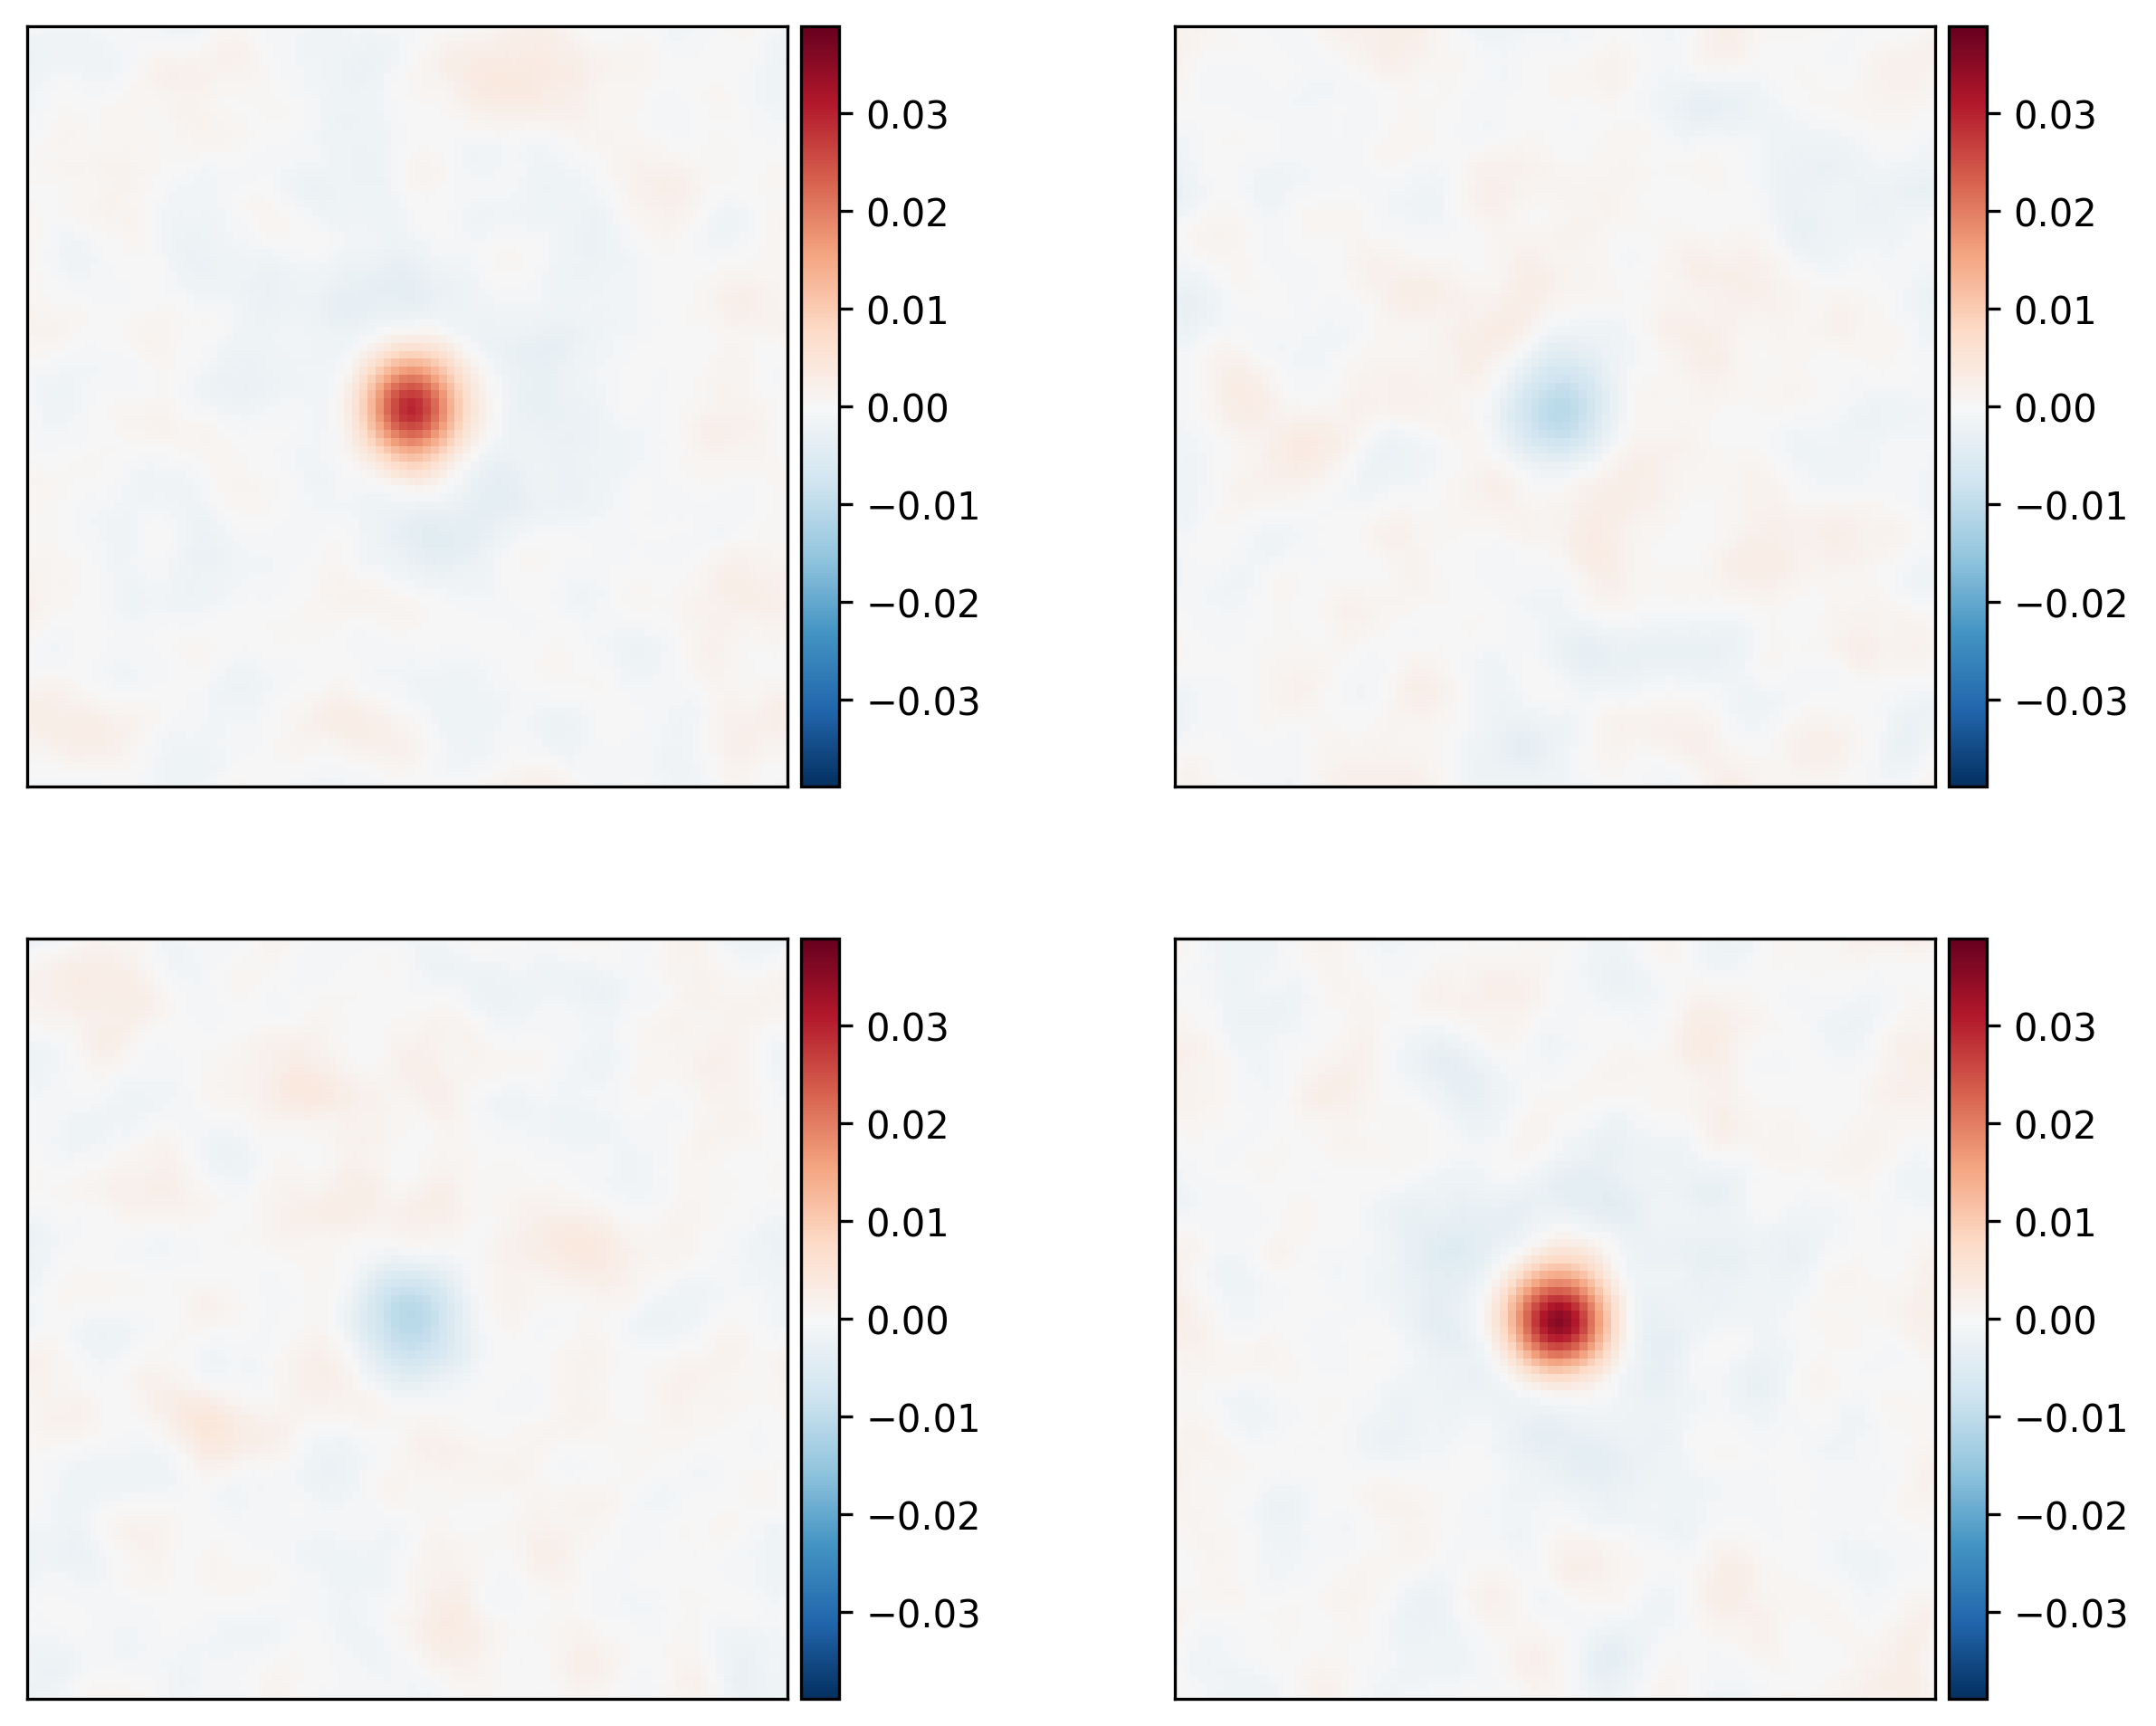

In [29]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

lim = np.max(np.abs(bett_full_cov))

pf.imshowbar(fig,axs[0,0],bett_NN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[0,1],bett_NF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[1,0],bett_FN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[1,1],bett_FF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)

In [30]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

bett_S_cov = np.zeros(72)
bett_S_cov_err = np.zeros(72)
bett_D_cov = np.zeros(72)
bett_D_cov_err = np.zeros(72)

for idx in range(72):
    bett_S_cov[idx] = 0.5*(np.mean(bett_NN_cov[bin_idxs == idx]) + np.mean(bett_FF_cov[bin_idxs == idx]))
    bett_S_cov_err[idx] = np.sqrt(np.var(bett_NN_cov[bin_idxs == idx]) + np.var(bett_FF_cov[bin_idxs == idx]))
    bett_D_cov[idx] = 0.5*(np.mean(bett_NF_cov[bin_idxs == idx]) + np.mean(bett_NF_cov[bin_idxs == idx]))
    bett_D_cov_err[idx] = np.sqrt(np.var(bett_NF_cov[bin_idxs == idx]) + np.var(bett_NF_cov[bin_idxs == idx]))

Text(0.5, 1.0, 'Bettina LGN Activity Covariance')

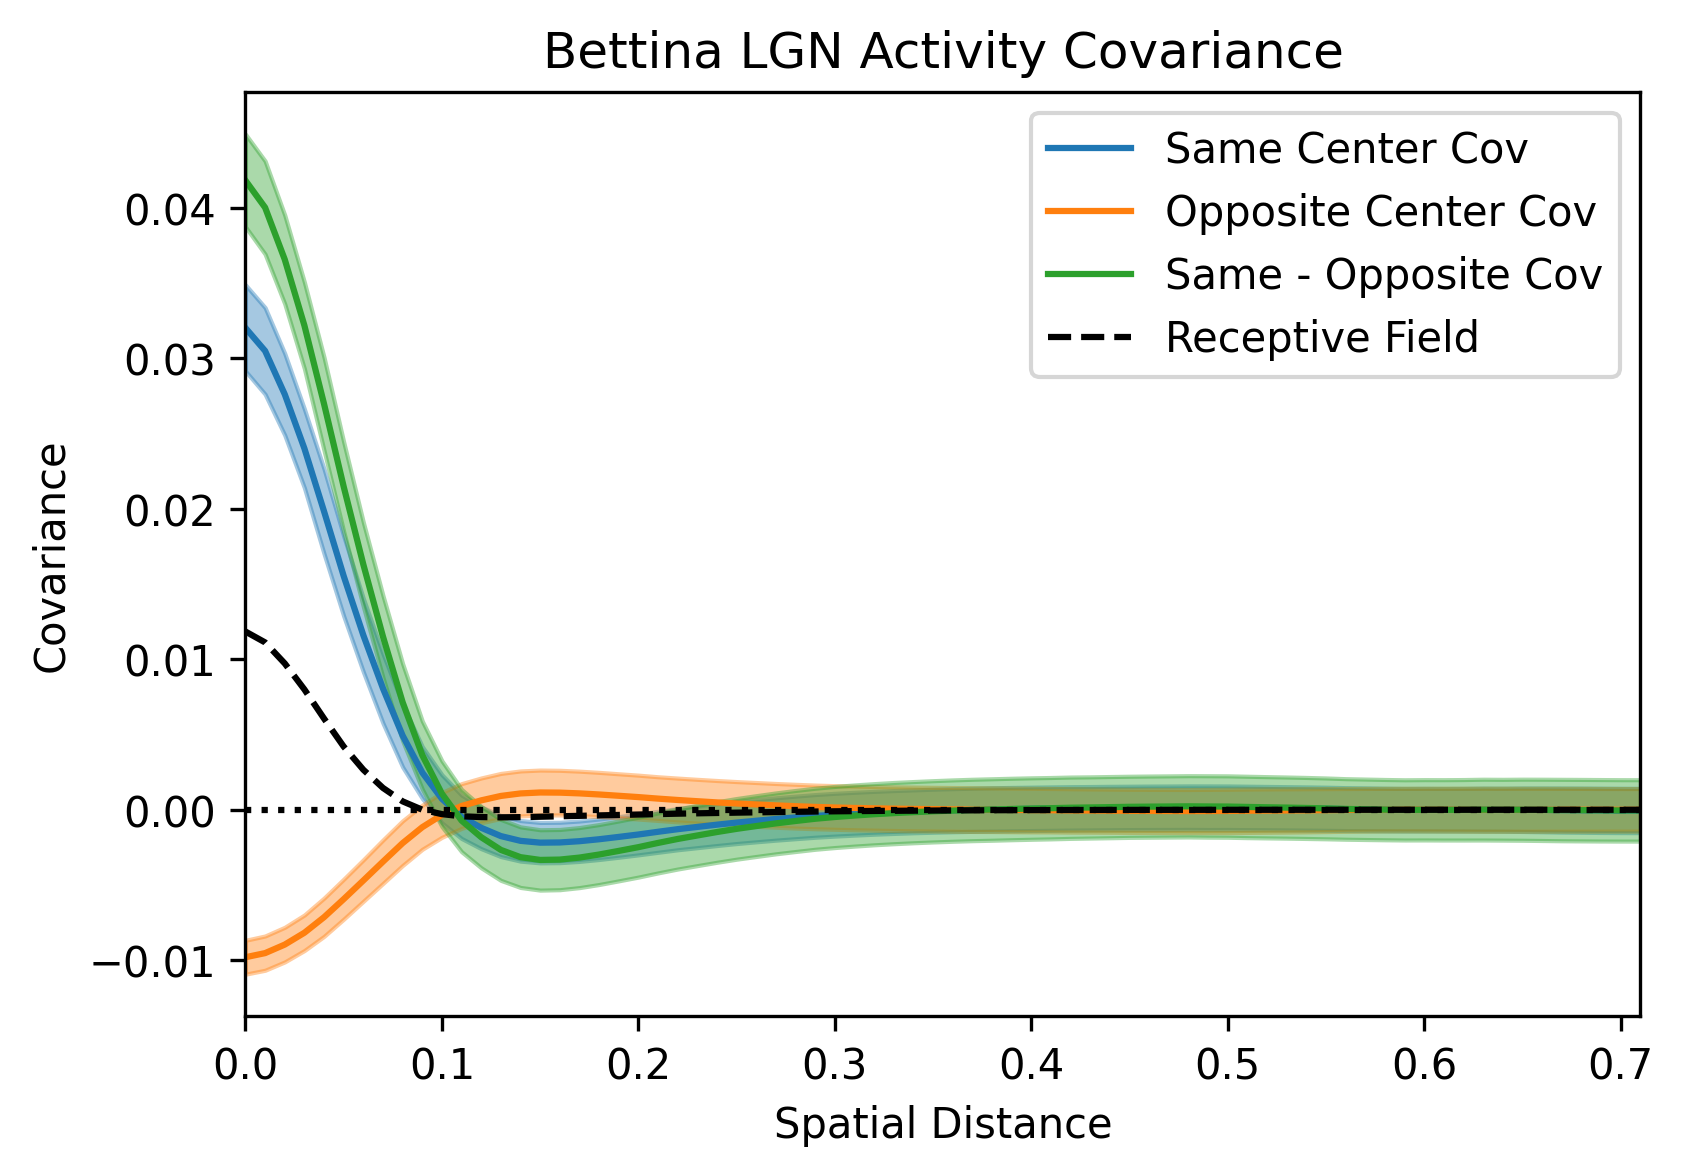

In [31]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,bett_S_cov,c='C0',label='Same Center Cov')
axs.fill_between(dists,bett_S_cov-bett_S_cov_err,bett_S_cov+bett_S_cov_err,color='C0',alpha=0.4)
axs.plot(dists,bett_D_cov,c='C1',label='Opposite Center Cov')
axs.fill_between(dists,bett_D_cov-bett_D_cov_err,bett_D_cov+bett_D_cov_err,color='C1',alpha=0.4)
axs.plot(dists,bett_S_cov-bett_D_cov,c='C2',label='Same - Opposite Cov')
axs.fill_between(dists,bett_S_cov-bett_D_cov-np.sqrt(bett_S_cov_err**2+bett_D_cov_err**2),
                 bett_S_cov-bett_D_cov+np.sqrt(bett_S_cov_err**2+bett_D_cov_err**2),color='C2',alpha=0.4)
axs.plot(dists,WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Bettina LGN Activity Covariance')

Text(0.5, 1.0, 'Bettina LGN Activity Covariance')

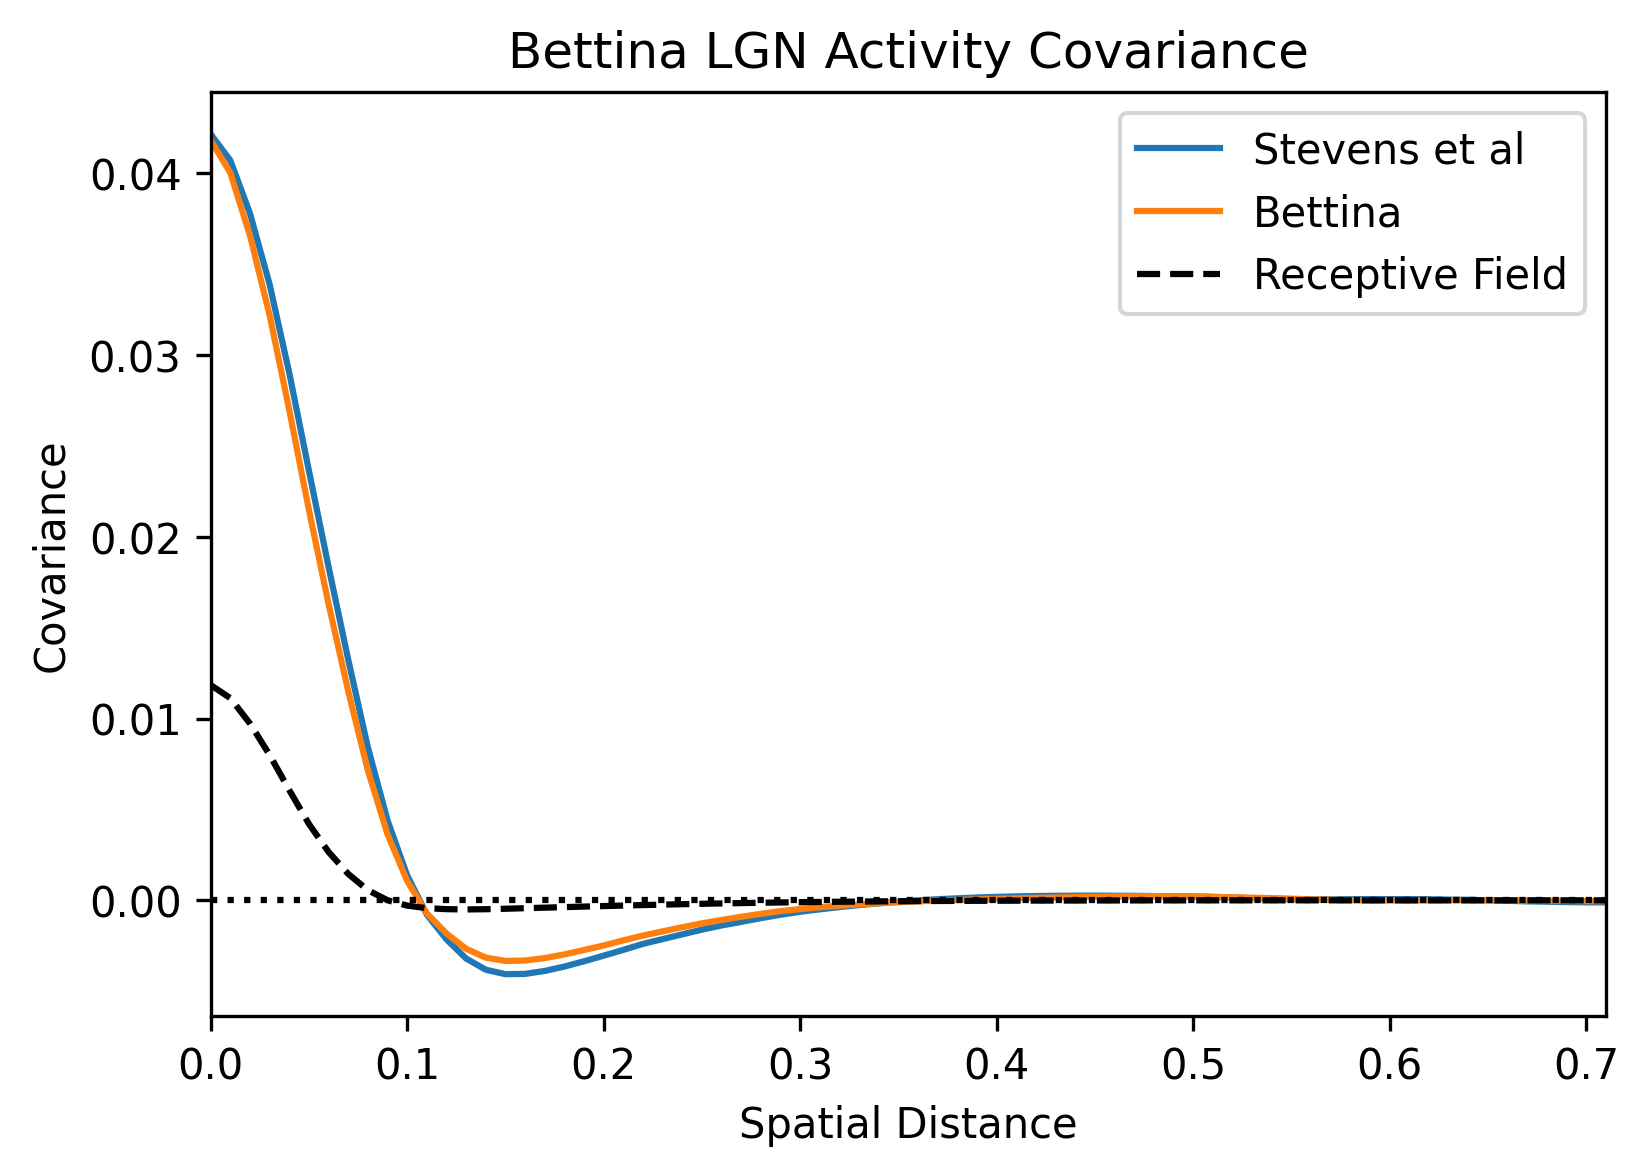

In [32]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,norm_S_cov - norm_D_cov,c='C0',label='Stevens et al')
axs.plot(dists,bett_S_cov - bett_D_cov,c='C1',label='Bettina')
axs.plot(dists,WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Bettina LGN Activity Covariance')